## Importing the required libraries 

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#pip install statsmodels
#pip install textblob
#pip install wordcloud

In [3]:
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense, Embedding, Activation, Dropout, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

## 1. Load the dataset

In [4]:
import pymysql
import mysql.connector
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, StringType, ArrayType, BooleanType, IntegerType

In [5]:
# SQL statement for creating the table
#sql = """
#CREATE TABLE non_d (
#  id BIGINT,
#  conversation_id BIGINT,
#  created_at BIGINT,
#  date VARCHAR(19),
#  timezone INT,
#  place VARCHAR(255),
#  tweet VARCHAR(255),
#  language VARCHAR(2),
#  hashtags VARCHAR(255),
#  cashtags VARCHAR(255),
#  user_id BIGINT,
#  user_id_str VARCHAR(20),
#  username VARCHAR(255),
#  name VARCHAR(255),
#  day INT,
#  hour INT,
#  link VARCHAR(255),
#  urls VARCHAR(255),
#  photos VARCHAR(255),
#  video INT,
#  thumbnail VARCHAR(255),
#  retweet BOOLEAN,
#  nlikes INT,
#  nreplies INT,
#  nretweets INT,
#  quote_url VARCHAR(255),
#  search VARCHAR(255),
#  near VARCHAR(255),
#  geo VARCHAR(255),
#  source VARCHAR(255),
#  user_rt_id VARCHAR(255),
#  user_rt VARCHAR(255),
#  retweet_id VARCHAR(255),
#  reply_to VARCHAR(255),
#  retweet_date VARCHAR(255),
#  translate VARCHAR(255),
#  trans_src VARCHAR(255),
#  trans_dest VARCHAR(255))"""

# Execute the SQL statement
#cursor.execute(sql)

# Commit the changes and close the connection
#connection.commit()
#connection.close()

In [6]:
# Connect to the MySQL database
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="twitter"
)

# Create a cursor object to execute SQL commands
cursor = connection.cursor()

# Execute the SQL query
query = "SELECT * FROM non_d"
cursor.execute(query)

# Fetch all the rows from the query result
rows = cursor.fetchall()

# Close the database connection
connection.close()

# Define the schema for the Spark DataFrame
schema = StructType([
    StructField("id", LongType(), nullable=True),
    StructField("conversation_id", StringType(), nullable=True),
    StructField("created_at", StringType(), nullable=True),
    StructField("date", StringType(), nullable=True),
    StructField("timezone", IntegerType(), nullable=True),
    StructField("place", StringType(), nullable=True),
    StructField("tweet", StringType(), nullable=True),
    StructField("hashtags", StringType(), nullable=True),
    StructField("cashtags", StringType(), nullable=True),
    StructField("user_id", LongType(), nullable=True),
    StructField("user_id_str", StringType(), nullable=True),
    StructField("username", StringType(), nullable=True),
    StructField("name", StringType(), nullable=True),
    StructField("day", IntegerType(), nullable=True),
    StructField("hour", IntegerType(), nullable=True),
    StructField("link", StringType(), nullable=True),
    StructField("urls", StringType(), nullable=True),
    StructField("photos", StringType(), nullable=True),
    StructField("thumbnail", StringType(), nullable=True),
    StructField("nreplies", IntegerType(), nullable=True),
    StructField("nretweets", IntegerType(), nullable=True),
    StructField("quote_url", StringType(), nullable=True),
    StructField("search", StringType(), nullable=True),
    StructField("near", StringType(), nullable=True),
    StructField("geo", StringType(), nullable=True),
    StructField("source", StringType(), nullable=True),
    StructField("user_rt_id", StringType(), nullable=True),
    StructField("user_rt", StringType(), nullable=True),
    StructField("retweet_id", StringType(), nullable=True),
    StructField("reply_to", StringType(), nullable=True),
    StructField("retweet_date", StringType(), nullable=True),
    StructField("trans_src", StringType(), nullable=True),
])

In [7]:
# Create a SparkSession
spark = SparkSession.builder.appName("PySpark_MySQL").getOrCreate()

# Create a list of rows using the fetched data
data = []
for row in rows:
    data.append(row)

# Create a Spark DataFrame from the data and the schema
dfs = spark.createDataFrame(data, schema=schema)

# Display the Spark DataFrame
dfs.show(5)

2023-05-25 12:47:47,791 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+---------------+----------+----+--------+-----+-----+--------+--------+-------+-----------+--------+----+----+----+----+----+------+---------+--------+---------+---------+------+----+----+------+----------+-------+----------+--------+------------+---------+
|                 id|conversation_id|created_at|date|timezone|place|tweet|hashtags|cashtags|user_id|user_id_str|username|name| day|hour|link|urls|photos|thumbnail|nreplies|nretweets|quote_url|search|near| geo|source|user_rt_id|user_rt|retweet_id|reply_to|retweet_date|trans_src|
+-------------------+---------------+----------+----+--------+-----+-----+--------+--------+-------+-----------+--------+----+----+----+----+----+------+---------+--------+---------+---------+------+----+----+------+----------+-------+----------+--------+------------+---------+
|1424756177682927617|           null|      null|null|    null| null| null|    null|    null|   null|       null|    null|null|null|null|null|null|  null|     null|

## 2. Data preparation

In [8]:
print("Number of rows:", dfs.count())

2023-05-25 12:47:49,837 WARN scheduler.TaskSetManager: Stage 1 contains a task of very large size (1617 KiB). The maximum recommended task size is 1000 KiB.


Number of rows: 14427


In [9]:
dfs.printSchema()

root
 |-- id: long (nullable = true)
 |-- conversation_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- date: string (nullable = true)
 |-- timezone: integer (nullable = true)
 |-- place: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- cashtags: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_id_str: string (nullable = true)
 |-- username: string (nullable = true)
 |-- name: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- link: string (nullable = true)
 |-- urls: string (nullable = true)
 |-- photos: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- nreplies: integer (nullable = true)
 |-- nretweets: integer (nullable = true)
 |-- quote_url: string (nullable = true)
 |-- search: string (nullable = true)
 |-- near: string (nullable = true)
 |-- geo: string (nullable = true)
 |-- source: string (nullable 

In [10]:
# Checking datatypes
dfs.dtypes

[('id', 'bigint'),
 ('conversation_id', 'string'),
 ('created_at', 'string'),
 ('date', 'string'),
 ('timezone', 'int'),
 ('place', 'string'),
 ('tweet', 'string'),
 ('hashtags', 'string'),
 ('cashtags', 'string'),
 ('user_id', 'bigint'),
 ('user_id_str', 'string'),
 ('username', 'string'),
 ('name', 'string'),
 ('day', 'int'),
 ('hour', 'int'),
 ('link', 'string'),
 ('urls', 'string'),
 ('photos', 'string'),
 ('thumbnail', 'string'),
 ('nreplies', 'int'),
 ('nretweets', 'int'),
 ('quote_url', 'string'),
 ('search', 'string'),
 ('near', 'string'),
 ('geo', 'string'),
 ('source', 'string'),
 ('user_rt_id', 'string'),
 ('user_rt', 'string'),
 ('retweet_id', 'string'),
 ('reply_to', 'string'),
 ('retweet_date', 'string'),
 ('trans_src', 'string')]

In [11]:
# Checking a shape of pyspark Dataframe
print((dfs.count(), len(dfs.columns)))

2023-05-25 12:47:51,280 WARN scheduler.TaskSetManager: Stage 4 contains a task of very large size (1617 KiB). The maximum recommended task size is 1000 KiB.


(14427, 32)


### 2.1. Handle duplicates

In [12]:
# Check for duplicates
print('Count of rows: {0}'.format(dfs.count()))
print('Count of distinct rows: {0}'.format(dfs.distinct().count()))

2023-05-25 12:47:51,820 WARN scheduler.TaskSetManager: Stage 7 contains a task of very large size (1617 KiB). The maximum recommended task size is 1000 KiB.


Count of rows: 14427


2023-05-25 12:47:52,291 WARN scheduler.TaskSetManager: Stage 10 contains a task of very large size (1617 KiB). The maximum recommended task size is 1000 KiB.


Count of distinct rows: 14427


no duplicates in DataFrame

In [13]:
# Remove rows with None values
df_cleaned=dfs.na.drop()

In [14]:
df_cleaned.show()

+-------------------+-------------------+-------------+-------------------+--------+-----+--------------------+--------------------+--------+---------+-----------+---------+----------+---+----+--------------------+--------------------+--------------------+--------------------+--------+---------+--------------------+--------------------+--------------------+--------------------+------+----------+-------+----------+--------+------------+---------+
|                 id|    conversation_id|   created_at|               date|timezone|place|               tweet|            hashtags|cashtags|  user_id|user_id_str| username|      name|day|hour|                link|                urls|              photos|           thumbnail|nreplies|nretweets|           quote_url|              search|                near|                 geo|source|user_rt_id|user_rt|retweet_id|reply_to|retweet_date|trans_src|
+-------------------+-------------------+-------------+-------------------+--------+-----+----------

2023-05-25 12:47:54,707 WARN scheduler.TaskSetManager: Stage 17 contains a task of very large size (1617 KiB). The maximum recommended task size is 1000 KiB.


### 2.2. Missing observations

In [15]:
# Checking a missing observations
from pyspark.sql.functions import col,sum
df_cleaned.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns)).show()

2023-05-25 12:47:55,604 WARN scheduler.TaskSetManager: Stage 18 contains a task of very large size (1617 KiB). The maximum recommended task size is 1000 KiB.


+---+---------------+----------+----+--------+-----+-----+--------+--------+-------+-----------+--------+----+---+----+----+----+------+---------+--------+---------+---------+------+----+---+------+----------+-------+----------+--------+------------+---------+
| id|conversation_id|created_at|date|timezone|place|tweet|hashtags|cashtags|user_id|user_id_str|username|name|day|hour|link|urls|photos|thumbnail|nreplies|nretweets|quote_url|search|near|geo|source|user_rt_id|user_rt|retweet_id|reply_to|retweet_date|trans_src|
+---+---------------+----------+----+--------+-----+-----+--------+--------+-------+-----------+--------+----+---+----+----+----+------+---------+--------+---------+---------+------+----+---+------+----------+-------+----------+--------+------------+---------+
|  0|              0|         0|   0|       0|    0|    0|       0|       0|      0|          0|       0|   0|  0|   0|   0|   0|     0|        0|       0|        0|        0|     0|   0|  0|     0|         0|      0|

**No missing values in DataFrame**

In [16]:
# Converting the PySpark DataFRame to a Pandas Dataframe
df=df_cleaned.toPandas()

2023-05-25 12:47:56,914 WARN scheduler.TaskSetManager: Stage 21 contains a task of very large size (1617 KiB). The maximum recommended task size is 1000 KiB.


In [17]:
df

,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,user_id,...,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,trans_src
0,1424756177682927617,1424756177682927617,1628523318000,2021-08-09 05:35:18,-1000,,Touch Passes are the new ASMR,[],[],101354595,...,from:ShaanVP -filter:replies,,,,,,,[],,
1,1424741357592084485,1424741357592084485,1628519784000,2021-08-09 04:36:24,-1000,,"""12 years ago",en,[],0,...,,from:ShaanVP -filter:replies,,,,,,,[],
2,1424739267553550337,1424739267553550337,1628519286000,2021-08-09 04:28:06,-1000,,"""There are 6",en,[],0,...,,from:ShaanVP -filter:replies,,,,,,,[],
3,1424733524234366985,1424733524234366985,1628517917000,2021-08-09 04:05:17,-1000,,"""Hey everyone",and you learn where you stand don’t fear the...,en,0,...,74,,from:ShaanVP -filter:replies,,,,,,,
4,1424504791527411712,1424504791527411712,1628463382000,2021-08-08 12:56:22,-1000,,"""I invested in 47 startups in a year. Here's h...",en,[],0,...,,from:ShaanVP -filter:replies,,,,,,,[],
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9613,1110983659404869633,1110983659404869633,1553714120000,2019-03-27 09:15:20,-1000,,"""Cardi B wants to trademark her catchphrase “O...","Paps?”""",en,0,...,False,8183,214,396,,from:ConanOBrien -filter:replies,,,,
9614,1110588536737226752,1110588536737226752,1553619915000,2019-03-26 07:05:15,-1000,,I’ll bet Kellyanne and George Conway have pret...,en,[],0,...,10606,767,719,,from:ConanOBrien -filter:replies,,,,,
9615,1110202213723328512,1110202213723328512,1553527808000,2019-03-25 05:30:08,-1000,,"""Fans are always asking me how they can watch ...",""""" now I finally have an answer that is legal....",en,0,...,False,3319,135,357,,from:ConanOBrien -filter:replies,,,,
9616,1110149513140940802,1110149513140940802,1553515244000,2019-03-25 02:00:44,-1000,,"""Ray Romano is a hilarious comedian",a kind soul,and a rare neurotic Italian. https://t.co/pf...,0,...,https://pbs.twimg.com/media/D2gLGUrWsAAe3Em.jpg,False,2917,94,88,,from:ConanOBrien -filter:replies,,,


In [18]:
# Checking datatypes
df.dtypes

id                  int64
conversation_id    object
created_at         object
date               object
timezone            int32
place              object
tweet              object
hashtags           object
cashtags           object
user_id             int64
user_id_str        object
username           object
name               object
day                 int32
hour                int32
link               object
urls               object
photos             object
thumbnail          object
nreplies            int32
nretweets           int32
quote_url          object
search             object
near               object
geo                object
source             object
user_rt_id         object
user_rt            object
retweet_id         object
reply_to           object
retweet_date       object
trans_src          object
dtype: object

## 2.3. Data cleaning

In [19]:
import nltk
nltk.download('punkt') # one time execution
nltk.download('stopwords')
from nltk.corpus import stopwords
# set stop_words that contains the English stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
%%time
import re
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data
#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data
#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data
#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

CPU times: user 5 µs, sys: 5 µs, total: 10 µs
Wall time: 29.1 µs


In [21]:
#remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df['clean_tweet']=df['tweet'].apply(lambda z: remove_stopwords(z))    
df['clean_tweet']=df['tweet'].apply(lambda z: remove_punctuations(z))
df['clean_tweet']=df['tweet'].apply(lambda z: remove_html(z))
df['clean_tweet']=df['tweet'].apply(lambda z: remove_url(z))
df['clean_tweet']=df['tweet'].apply(lambda z: remove_emoji(z))

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
print(df['clean_tweet'])

0                           Touch Passes are the new ASMR
1                                           "12 years ago
2                                            "There are 6
3                                           "Hey everyone
4       "I invested in 47 startups in a year. Here's h...
                              ...                        
9613    "Cardi B wants to trademark her catchphrase “O...
9614    I’ll bet Kellyanne and George Conway have pret...
9615    "Fans are always asking me how they can watch ...
9616                  "Ray Romano is a hilarious comedian
9617                    "Mueller's report may be finished
Name: clean_tweet, Length: 9618, dtype: object


In [23]:
df.shape

(9618, 33)

In [24]:
# Setting max lenght of a tweet and max number of words to be included in the vocabulary
max_len = 100
max_words = 10000
# the tokenizer
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df['clean_tweet'])
# method called on the tokenizer object to convert the text data
sequences = tokenizer.texts_to_sequences(df['clean_tweet'])
# word_index dictionary containing the words and their corresponding integer values
word_index = tokenizer.word_index
# calling to pad the sequences to a fixed lenght of max_len
data = pad_sequences(sequences, maxlen=max_len)

# 3. Sentiment Analysis

## 3.1. Polarity

In [25]:
# polarity takes a text as input and returns the polarity score of the text using the TextBlob library.
def polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [26]:
# Applied clean_tweet to polarity
df['sentiment_polarity'] = df['clean_tweet'].apply(polarity)

In [27]:
# converting function of the sentoment score to sentiment text
df['sentiment'] = np.where(df['sentiment_polarity'] >= 0, 'positive', 'negative')
df.head(5)

,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,user_id,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,trans_src,clean_tweet,sentiment_polarity,sentiment
0,1424756177682927617,1424756177682927617,1628523318000,2021-08-09 05:35:18,-1000,,Touch Passes are the new ASMR,[],[],101354595,...,,,,,[],,,Touch Passes are the new ASMR,0.136364,positive
1,1424741357592084485,1424741357592084485,1628519784000,2021-08-09 04:36:24,-1000,,"""12 years ago",en,[],0,...,,,,,,[],,"""12 years ago",0.000000,positive
2,1424739267553550337,1424739267553550337,1628519286000,2021-08-09 04:28:06,-1000,,"""There are 6",en,[],0,...,,,,,,[],,"""There are 6",0.000000,positive
3,1424733524234366985,1424733524234366985,1628517917000,2021-08-09 04:05:17,-1000,,"""Hey everyone",and you learn where you stand don’t fear the...,en,0,...,,,,,,,,"""Hey everyone",0.000000,positive
4,1424504791527411712,1424504791527411712,1628463382000,2021-08-08 12:56:22,-1000,,"""I invested in 47 startups in a year. Here's h...",en,[],0,...,,,,,,[],,"""I invested in 47 startups in a year. Here's h...",0.000000,positive


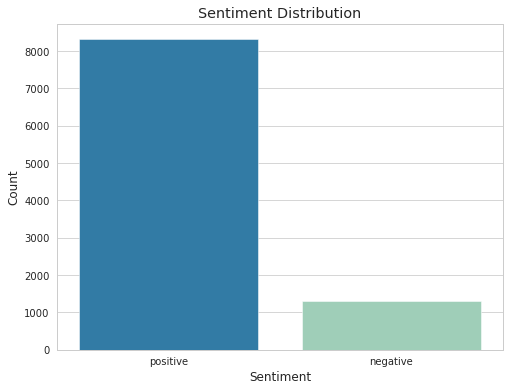

In [28]:
# Plot of the sentiment values
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='YlGnBu_r')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [29]:
# label encoding
label_encoder = LabelEncoder()
# The numerical labels for the categorical values in the 'sentiment' column
labels = label_encoder.fit_transform(df['sentiment'])
# Reshaping
labels = labels.reshape(-1, 1)

In [30]:
df1 = df[['clean_tweet', 'sentiment']]
df1.head()

,clean_tweet,sentiment
0,Touch Passes are the new ASMR,positive
1,"""12 years ago",positive
2,"""There are 6",positive
3,"""Hey everyone",positive
4,"""I invested in 47 startups in a year. Here's h...",positive


## 3.2. Apply to the model

In [31]:
# Apply Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train.shape

(7694, 100)

In [32]:
# Define the model architecture
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(len(word_index) + 1, 128, input_length=max_len)(input_layer)
x = GlobalMaxPooling1D()(embedding_layer)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 128)          1109248   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

In [33]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
# Define the callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# Fit the model
tweet = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 4s 14ms/step - loss: 0.4266 - accuracy: 0.8581 - val_loss: 0.3752 - val_accuracy: 0.8669
Epoch 2/10
241/241 [==============================] - 3s 10ms/step - loss: 0.3235 - accuracy: 0.8647 - val_loss: 0.2565 - val_accuracy: 0.8851
Epoch 3/10
241/241 [==============================] - 2s 10ms/step - loss: 0.1306 - accuracy: 0.9568 - val_loss: 0.1353 - val_accuracy: 0.9579
Epoch 4/10
241/241 [==============================] - 2s 9ms/step - loss: 0.0375 - accuracy: 0.9916 - val_loss: 0.0966 - val_accuracy: 0.9745
Epoch 5/10
241/241 [==============================] - 2s 9ms/step - loss: 0.0141 - accuracy: 0.9979 - val_loss: 0.0916 - val_accuracy: 0.9813
Epoch 6/10
241/241 [==============================] - 2s 9ms/step - loss: 0.0059 - accuracy: 0.9996 - val_loss: 0.0930 - val_accuracy: 0.9771
Epoch 7/10
241/241 [==============================] - 2s 9ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1014 - val_accuracy: 0.9792
Epo

In [35]:
# Evaluation of Model
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test loss:', model_score[0])
print('Test accuracy:', model_score[1])

31/31 [==============================] - 0s 2ms/step - loss: 0.1032 - accuracy: 0.9792
Test loss: 0.10318781435489655
Test accuracy: 0.9792099595069885


In [36]:
# Prediction
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

61/61 [==============================] - 0s 1ms/step


**Confusion matrix**

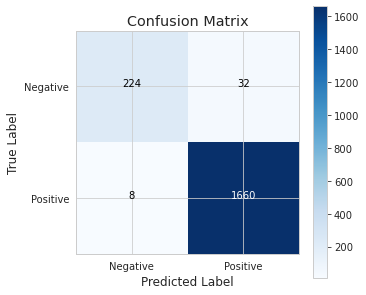

              precision    recall  f1-score   support

    Negative       0.97      0.88      0.92       256
    Positive       0.98      1.00      0.99      1668

    accuracy                           0.98      1924
   macro avg       0.97      0.94      0.95      1924
weighted avg       0.98      0.98      0.98      1924



In [37]:
# Calculate cm by calling a method named as 'confusion_matrix'
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
# print the classification_report based on y_test and y_pred_classes
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

**Loss and accuracy plots**

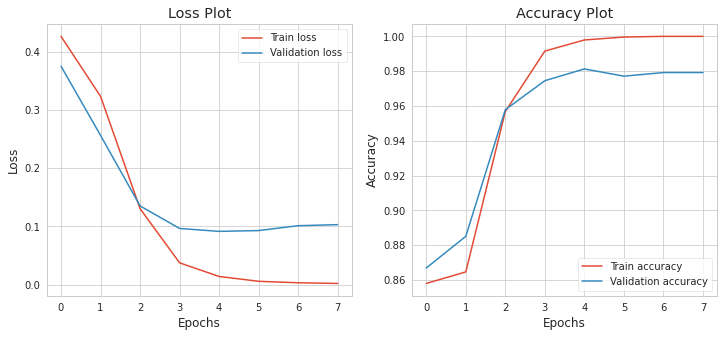

In [38]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tweet.history['loss'], label='Train loss')
plt.plot(tweet.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tweet.history['accuracy'], label='Train accuracy')
plt.plot(tweet.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

**ROC curve**

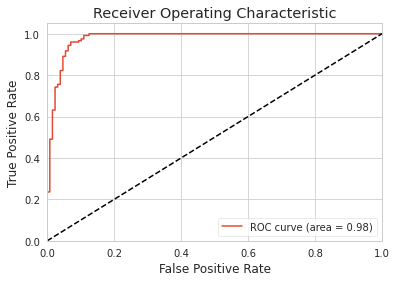

In [39]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Time Series Forecasting 

In [40]:
# Creating a new DataFrame for df_tsf with date and sentiment_polarity
df_tsf=df[["date", "sentiment_polarity"]]

In [41]:
df_tsf['date'] = pd.to_datetime(df_tsf['date'])
print('Min date from train set: %s' % df_tsf['date'].min().date())
print('Max date from train set: %s' % df_tsf['date'].max().date())

Min date from train set: 2012-10-08
Max date from train set: 2021-08-09


/tmp/ipykernel_25762/856038962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tsf['date'] = pd.to_datetime(df_tsf['date'])


In [42]:
#pip install prophet
from prophet import Prophet

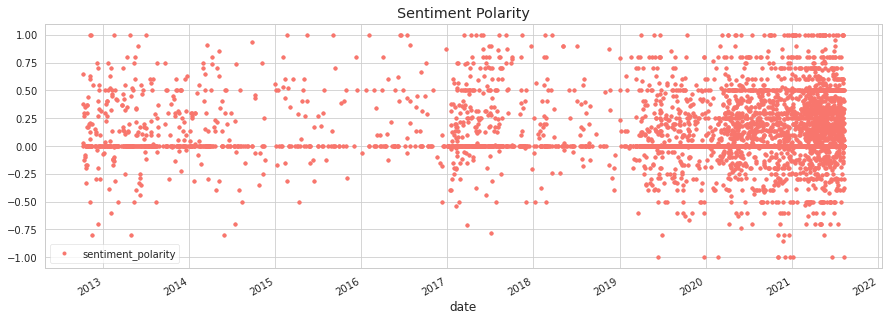

In [43]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df_tsf.plot(style='.', x="date", figsize=(15,5), color=color_pal[0], title='Sentiment Polarity')
plt.show()

In [44]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_tsf, label='sentiment_polarity')

features_and_target = pd.concat([X, y], axis=1)

/tmp/ipykernel_25762/928907067.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [45]:
# See our features and target
features_and_target

,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,sentiment_polarity
1970-01-01 00:00:00.000000000,5,0,8,2021,221,9,32,0.136364
1970-01-01 00:00:00.000000001,4,0,8,2021,221,9,32,0.000000
1970-01-01 00:00:00.000000002,4,0,8,2021,221,9,32,0.000000
1970-01-01 00:00:00.000000003,4,0,8,2021,221,9,32,0.000000
1970-01-01 00:00:00.000000004,12,6,8,2021,220,8,31,0.000000
...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000009613,9,2,3,2019,86,27,13,0.100000
1970-01-01 00:00:00.000009614,7,1,3,2019,85,26,13,-0.125000
1970-01-01 00:00:00.000009615,5,0,3,2019,84,25,13,0.100000
1970-01-01 00:00:00.000009616,2,0,3,2019,84,25,13,0.500000


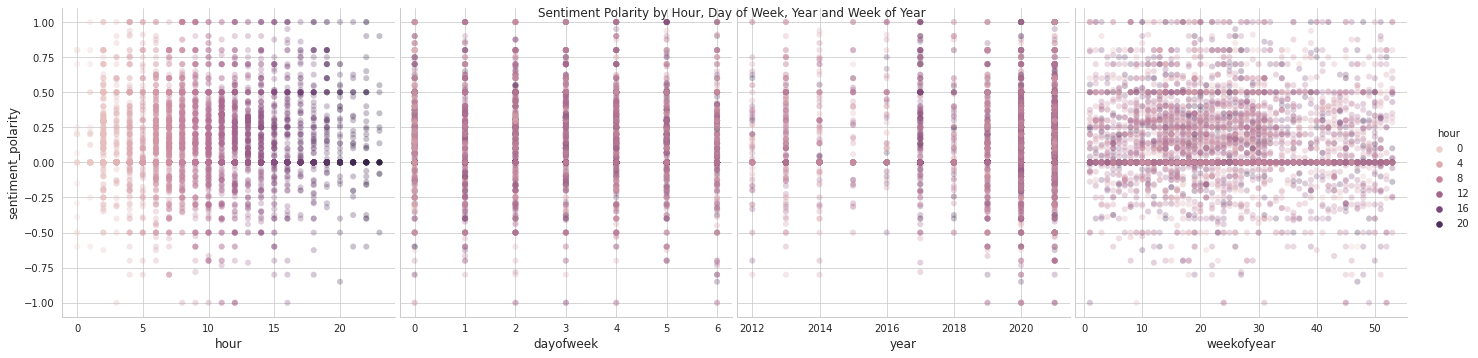

In [46]:
# Makring a scatter plots of 'sentiment_polarity' against 'hour', 'dayofweek', 'year', and 'weekofyear
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='sentiment_polarity',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Sentiment Polarity by Hour, Day of Week, Year and Week of Year')
plt.show()

In [47]:
from datetime import timedelta
df['date'] = pd.to_datetime(df['date'])

In [48]:
# Calculate the average sentiment polarity by day
average_polarity = df.groupby(df['date'].dt.date)['sentiment_polarity'].mean()
average_polarity_df = pd.DataFrame({'date': average_polarity.index, 'average_polarity': average_polarity.values})

In [49]:
# Set the 'date' column as the index
average_polarity_df['date'] = pd.to_datetime(average_polarity_df['date'])
average_polarity_df.set_index('date', inplace=True)

In [50]:
# Perform week forecasting by day
# Resample to weekly frequency and forward fill missing values
weekly_average_polarity = average_polarity_df.resample('W').ffill()

In [51]:
# Add an additional WEEK for forecasting
last_date = weekly_average_polarity.index[-1]
forecast_date = last_date + pd.DateOffset(weeks=1)
forecasted_value = weekly_average_polarity.iloc[-1]['average_polarity']
forecast = pd.DataFrame({'date': [forecast_date], 'average_polarity': [forecasted_value]})
forecast['date'] = pd.to_datetime(forecast['date'])
forecast.set_index('date', inplace=True)

In [52]:
# Concatenate the original data and forecasted data
weekly = pd.concat([weekly_average_polarity, forecast])

In [53]:
# Print the result
print(weekly)

            average_polarity
date                        
2012-10-14          0.266667
2012-10-21         -0.333333
2012-10-28          0.244444
2012-11-04          0.200000
2012-11-11          0.500000
...                      ...
2021-07-25          0.067857
2021-08-01          0.050000
2021-08-08         -0.077381
2021-08-15          0.114558
2021-08-22          0.114558

[463 rows x 1 columns]


In [54]:
# Splitting train and test
train = weekly[weekly.index < pd.to_datetime("2021-06-01")]
test = weekly[weekly.index >= pd.to_datetime("2021-06-01")]
test

,average_polarity
date,
2021-06-06,0.085000
2021-06-13,0.054167
2021-06-20,0.051389
2021-06-27,0.100000
2021-07-04,0.047619
2021-07-11,0.039302
2021-07-18,0.203504
2021-07-25,0.067857
2021-08-01,0.050000


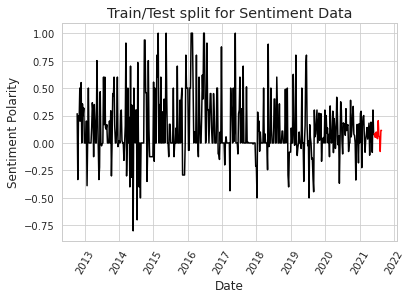

In [55]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Sentiment Polarity')
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.title("Train/Test split for Sentiment Data")
plt.show()

In [56]:
# Add an additional DAY for forecasting
last_date = average_polarity_df.index[-1]
forecast_date = last_date + pd.DateOffset(days=1)
forecasted_value = average_polarity_df.iloc[-1]['average_polarity']
forecast = pd.DataFrame({'date': [forecast_date], 'average_polarity': [forecasted_value]})
forecast['date'] = pd.to_datetime(forecast['date'])
forecast.set_index('date', inplace=True)

In [57]:
daily = pd.concat([average_polarity_df, forecast])


In [58]:
print(daily)

            average_polarity
date                        
2012-10-08          0.000000
2012-10-09          0.026111
2012-10-10          0.442929
2012-10-11         -0.125000
2012-10-12          0.266667
...                      ...
2021-08-06          0.296006
2021-08-07          0.173377
2021-08-08         -0.077381
2021-08-09          0.114558
2021-08-10          0.114558

[1692 rows x 1 columns]


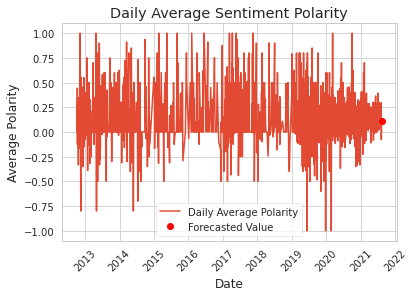

In [59]:
# Plot the monthly average sentiment polarity
plt.plot(daily.index, daily['average_polarity'], label='Daily Average Polarity')
# Plot the forecasted value
plt.plot(daily.index[-1], daily['average_polarity'].iloc[-1], 'ro', label='Forecasted Value')
# Set the plot title and labels
plt.title('Daily Average Sentiment Polarity')
plt.xlabel('Date')
plt.ylabel('Average Polarity')
# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)
# Display the legend
plt.legend()
plt.show()

**4.1. Prophet forecasting**

In [60]:
# Splitting train and test
d_train = daily[daily.index < pd.to_datetime("2020-06-01")]
d_test = daily[daily.index >= pd.to_datetime("2020-06-01")]
d_test

,average_polarity
date,
2020-06-01,0.105556
2020-06-02,0.001389
2020-06-03,0.545679
2020-06-04,0.297222
2020-06-05,0.416667
...,...
2021-08-06,0.296006
2021-08-07,0.173377
2021-08-08,-0.077381


In [61]:
# Setup and train model and fit
model = Prophet()
model.fit(d_train.reset_index() \
              .rename(columns={'date':'ds',
                               'average_polarity':'y'}))

12:48:24 - cmdstanpy - INFO - Chain [1] start processing
12:48:24 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
# Predict on training set with model
d_test_fcst = model.predict(df=d_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

In [63]:
d_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-01,0.079739,-0.276237,0.417851,0.079739,0.079739,0.002408,0.002408,0.002408,0.020975,0.020975,0.020975,-0.018567,-0.018567,-0.018567,0.0,0.0,0.0,0.082147
1,2020-06-02,0.079671,-0.316783,0.387828,0.079671,0.079671,-0.044723,-0.044723,-0.044723,-0.029651,-0.029651,-0.029651,-0.015072,-0.015072,-0.015072,0.0,0.0,0.0,0.034948
2,2020-06-03,0.079603,-0.277682,0.382828,0.079603,0.079603,-0.026408,-0.026408,-0.026408,-0.015667,-0.015667,-0.015667,-0.010741,-0.010741,-0.010741,0.0,0.0,0.0,0.053195
3,2020-06-04,0.079535,-0.247981,0.423998,0.079535,0.079535,0.013033,0.013033,0.013033,0.018725,0.018725,0.018725,-0.005692,-0.005692,-0.005692,0.0,0.0,0.0,0.092568
4,2020-06-05,0.079467,-0.239897,0.441007,0.079467,0.079467,0.015478,0.015478,0.015478,0.015538,0.015538,0.015538,-0.000059,-0.000059,-0.000059,0.0,0.0,0.0,0.094946


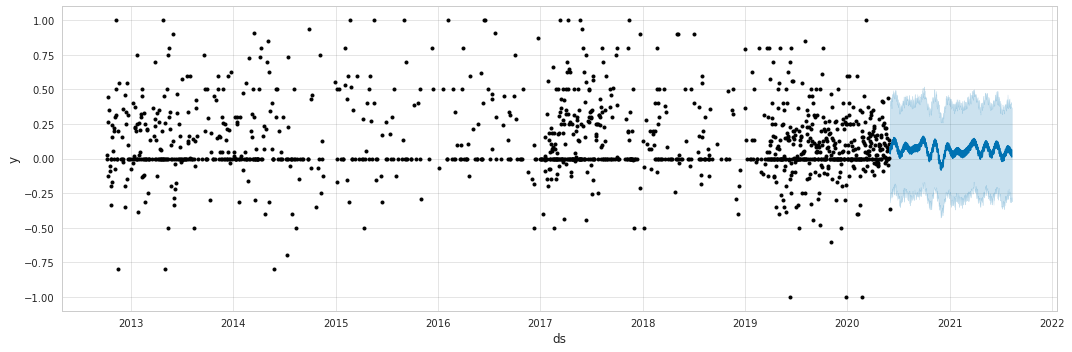

In [64]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(d_test_fcst,
                 ax=ax)
plt.show()

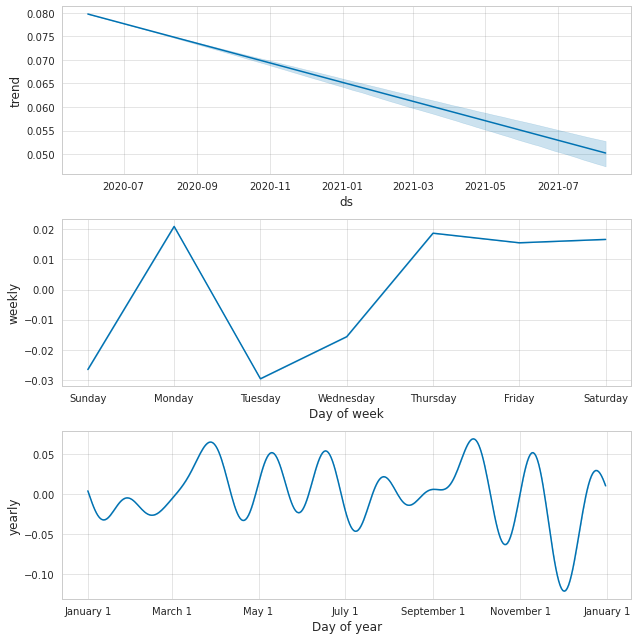

In [65]:
# Plot the components of the model
fig = model.plot_components(d_test_fcst)

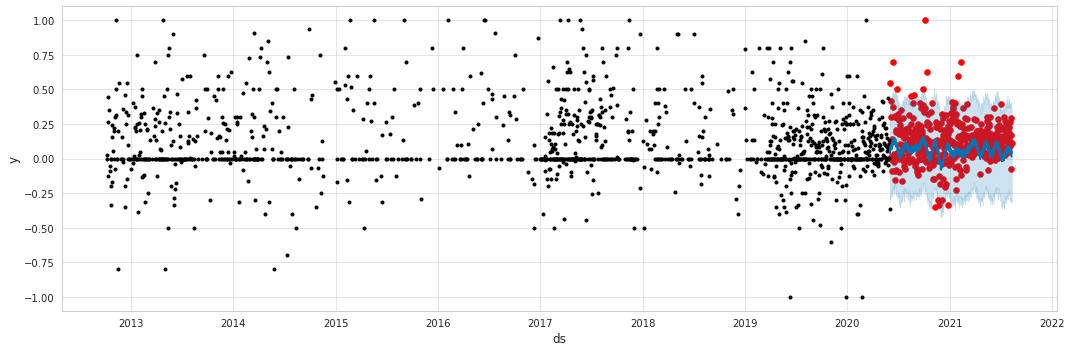

In [67]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(d_test.index, d_test['average_polarity'], color='r')
fig = model.plot(d_test_fcst, ax=ax)

**4.2. LSTM forecasting**

In [68]:
daily

,average_polarity
date,
2012-10-08,0.000000
2012-10-09,0.026111
2012-10-10,0.442929
2012-10-11,-0.125000
2012-10-12,0.266667
...,...
2021-08-06,0.296006
2021-08-07,0.173377
2021-08-08,-0.077381


In [69]:
# Create a new dataframe with the sentiment_polarity column shifted 30 days into the future
df_shifted = pd.DataFrame({'sentiment_polarity': daily['average_polarity'].shift(-30)})

In [70]:
# Drop the last 30 rows of the original dataframe
daily.drop(daily.tail(30).index, inplace=True)

In [71]:
# Convert the dataframes to numpy arrays
X = daily.values
y = df_shifted.values

In [72]:
import datetime
# Convert any Timestamp features in X to numerical data type
for i in range(X.shape[1]):
    if isinstance(X[0,i], datetime.datetime):
        X[:,i] = [dt.timestamp() for dt in X[:,i]]

In [73]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size,:], y[train_size:len(y),:]

In [74]:
# Reshape the data for LSTM input
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [102]:
# Define the model architecture
model = Sequential()
model.add(LSTM(units=1000, input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1000)              4008000   
                                                                 
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 dense_8 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 4,010,002
Trainable params: 4,010,002
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [104]:
# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32)

Epoch 1/10
42/42 [==============================] - 3s 39ms/step - loss: 0.2080
Epoch 2/10
42/42 [==============================] - 1s 34ms/step - loss: 0.2080
Epoch 3/10
42/42 [==============================] - 2s 47ms/step - loss: 0.2080
Epoch 4/10
42/42 [==============================] - 1s 28ms/step - loss: 0.2080
Epoch 5/10
42/42 [==============================] - 1s 25ms/step - loss: 0.2080
Epoch 6/10
42/42 [==============================] - 1s 24ms/step - loss: 0.2080
Epoch 7/10
42/42 [==============================] - 1s 34ms/step - loss: 0.2080
Epoch 8/10
42/42 [==============================] - 1s 25ms/step - loss: 0.2080
Epoch 9/10
42/42 [==============================] - 1s 25ms/step - loss: 0.2080
Epoch 10/10
42/42 [==============================] - 2s 39ms/step - loss: 0.2080


In [105]:
# Make the forecast
forecast = model.predict(X_test_reshaped)

11/11 [==============================] - 0s 8ms/step


In [106]:
# Extract the sentiment polarity values from the forecast and the actual values
forecast_sentiment = forecast[:,0]
actual_sentiment = y_test[:,0]

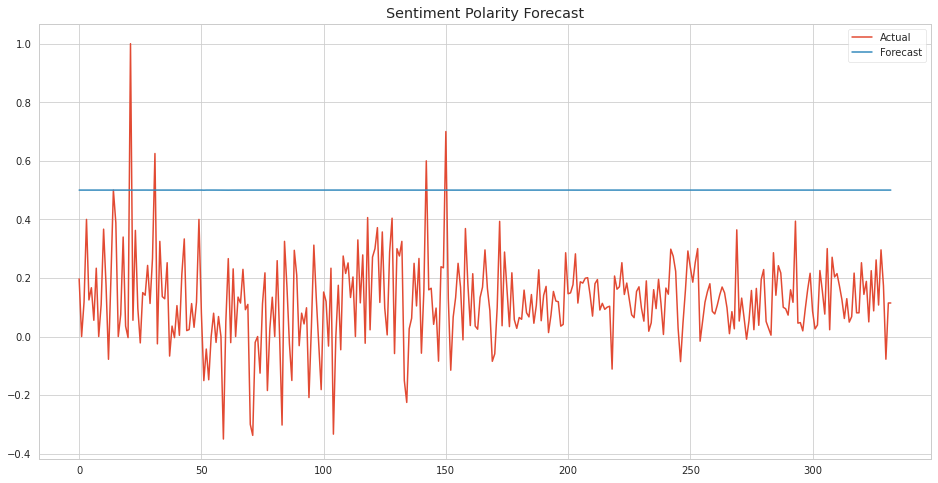

In [110]:
# Plot the actual and forecasted sentiment polarity values
plt.figure(figsize=(16,8))
plt.title('Sentiment Polarity Forecast')
plt.plot(actual_sentiment, label='Actual')
plt.plot(forecast_sentiment, label='Forecast')
plt.legend()
plt.show()

## Creating Interactive Dashboards 

In [108]:
#pip install dash
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output

In [109]:
app=Dash()
colors = {
    'background': '#111111',
    'text': '#7FDBFF'}
# Create the line plot of daily tweet counts
fig = px.bar(df, x='date', y='sentiment_polarity')

fig.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text'])

app.layout=html.Div(style={'backgroundColor': colors['background']}, children=[
    html.H1(
        children='Daily Tweet Polarity',
        style={
            'textAlign': 'center',
            'color': colors['text']
        }
    ),
    html.Div(children='Polarity', style={
        'textAlign': 'center',
        'color': colors['text']
    }),
     dcc.Graph(
        id='example-graph',
        figure=fig)
])


In [83]:
#app.run_server()